# Fitting the Hipparcos-Gaia Catalog of Acclerations (HGCA)

Jason Wang (2023)

We will demonstrate how to fit the stellar absolute astrometry from the [Hipparcos-Gaia Catalog of Accelerations (HGCA; Brandt 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJS..254...42B/abstract) to help constrain the mass and orbital parameters of the companion. The implementation of fitting the HGCA here is based on [Brandt et al. 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....158..140B/abstract), but utilizes the DR3 version of the HGCA. 

## Difference to fitting IAD directly

This method is an alternative to fitting the Hipparcos IAD and Gaia astrometry. Instead of fitting the individual epochs of Hipparcos data, which also includes needing to fit for the position, proper motion, and parallax of the star, we are only fitting for two differential proper motions: the proper motion difference between Hipparcos and the change in position between Hipparcos and Gaia; the proper motion difference between Gaia and the change in position between Hipparcos and Gaia. This simplifies the fit, but also ignores any detectable curvature in the stellar astrometry seen by Hipparcos. For planet companion cases, the acceleration should be well within the noise of the Hipparcos measurements. 

The benefit of using this technique is that the errors should be more robust. The HGCA catalog inflates the error bars from the Hipparcos and Gaia measurements on a global scale to match the true observed scatter in the data. Additionally, there are bad epochs in the Hipparcos IAD that may not be removed. 

We encourage users to try both to see how similar or different the results are, as the two methods utilize the same underlying data. 


## Obtain the necessary data

While `orbitize!` will automatically download the HGCA catalog, you need to obtain two other data files to reconstruct the Hipparcos and Gaia observations for your star. These files tell us when and in what orientation did Hipparcos and Gaia take data of the star for the forward modeling that happens in `orbitize!`. 

  1. The Hipparcos IAD file of the star. Follow the section in the [Hipparocs IAD tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Hipparcos_IAD.html#Part-1:-Obtaining-the-IAD) on how to obtain this file for your star of interest.
  2. The anticipated Gaia epochs and scan directions in a CSV file that is obtained from the [Gaia Observation Forecast Tool (GOST)](https://gaia.esac.esa.int/gost/). For GOST, after entering the target name and resolving its coordinates, use 2014-07-26T00:00:00 as the start date. For the end date, use 2016-05-23T00:00:00 for DR2 and 2017-05-28T00:00:00 for EDR3. You probably will be fitting the EDR3. The output CSV file is all you need. 

## Setup the `HGCALogProb` Object

The user just needs to setup the `orbitize.gaia.HGCALogProb` object, which will handle the rest of the HGCA modeling under the hood. To setup the `HGCALogProb` object, we also need to create an `orbitize.hipparcos.HipparcosLogProb` instance, but it will not actually be used in the fitting. It is simply used to handle reading in the Hipparcos IAD to maximize code reuse. 

In the example below, we setup the HGCA fitting for beta Pictoris (HIP 27321).


In [1]:
import os
from orbitize import DATADIR, hipparcos, gaia

# the necessary input data for beta Pic is part of the orbitize! example data!
iad_filepath = os.path.join(DATADIR, "HIP027321.d")
gost_filepath = os.path.join(DATADIR, "gaia_edr3_betpic_epochs.csv")

# Create the HGCA and helper Hipparcos object
# we're just going to assume one planet for simplicity
hipparcos_lnprob = hipparcos.HipparcosLogProb(iad_filepath, 27321, 1)
hgca_lnprob = gaia.HGCALogProb(27321, hipparcos_lnprob, gost_filepath)

Using HGCA catalog stored in /home/sblunt/Projects/orbitize/orbitize/example_data/HGCA_vEDR3.fits


## Setup orbit fit

After you do this step, the rest of the orbit fit setup is basically the same as a standard `orbitize!` orbit fit. The only differences is that you need to pass the `HGCALogProb` object into the system class (but not the `HipparcosLogProb` because the Hipparcos data is already being handled in HGCA). We also recommend you explicitly set up the system to fit for the dynamical mass of the companions in the system (this should happen automatically with the inclusion of HGCA data, but we recommend being explicit so it is clear what you are fitting for).

We will also note that that the default prior on the companion mass is a log-uniform prior between 1e-6 and 2 solar masses. If you want a more restricted mass, now is also the time to adjust that. We present one example here, but refer to the Modifying Priors tutorial for further details. 

In [2]:
from orbitize import read_input, system, priors
import astropy.units as u

# read in relative astrometry
astrometry_filepath = os.path.join(DATADIR, "betaPic.csv")
data_table = read_input.read_file(astrometry_filepath)

# set up the system, passing in hgca_lnprob and setting it fit dynamical mass
stellar_mass = 1.75
stellar_mass_err = 0.05
plx = 51.44
plx_err = 0.12

this_system = system.System(
    1,
    data_table,
    stellar_mass,
    plx,
    mass_err=stellar_mass_err,
    plx_err=plx_err,
    fit_secondary_mass=True,
    gaia=hgca_lnprob,
)

# adjust the prior on mass to be log uniform between 1 and 50 Jupiter masses
mjup = u.Mjup.to(u.Msun)
this_system.sys_priors[this_system.param_idx["m1"]] = priors.LogUniformPrior(
    mjup, 50 * mjup
)

## Run orbitize! 

From here onwards, everything is the same as an regular `orbitize` fit, so we refer to reader to the other tutorials. We recommend using the MCMC sampler, since the orbits are generally too constrained for OFTI. To pick the right number of temperatures, walkers, steps for MCMC, check out papers that performed similar fits (e.g., Section 3.1 of [GRAVITY Collaboration et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) and Section 3.1 of [Hinkley et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...671L...5H/abstract)).

In [3]:
from orbitize import sampler

# MCMC parameters
# for demonstration purposes only. You will need to increase these likely
n_temps = 2
n_walkers = 50
n_threads = 1
burn_steps = 1
total_orbits = 100 * n_walkers

# create the sampler, run it, and save posteriors
this_sampler = sampler.MCMC(this_system, n_temps, n_walkers, n_threads)

this_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=10)

this_sampler.results.save_results("demo_hgca.hdf5")

Starting Burn in


/home/sblunt/Projects/orbitize/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sblunt/Projects/orbitize/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)



Burn in complete. Sampling posterior now.
100/100 steps completed
Run complete


## Plot proper motions from the orbit fit over the HGCA observations

William Balmer (2023)

Now, you can plot the result of your fit using the  `orbitize.plot.plot_propermotion` function directly, or it's wrapper within the `sampler.results` object. The function is similar to `orbitize.plot.plot_orbits` that you may already be familiar with. These plots show the H-G proper motion (with a large x-axis error bar) in addition to the two "real" proper motion measurements from Hipparchos and Gaia.

Note that the HGCALogprob fits for the time-averaged proper motions, and not the instantaneous proper motions that are shown in this visualization. This is a subtle point, but important, because the data points show over the orbits here are not exactly what is driving the MCMC solver towards the most likely orbits.

Important Note of Caution: the orbitize! implementation of the HGCA 
 fits for the time-averaged proper motions, and not the instantaneous proper 
 motions that are being plotted here. This plot is provided only for the 
 purpose of an approximate check on the fit.


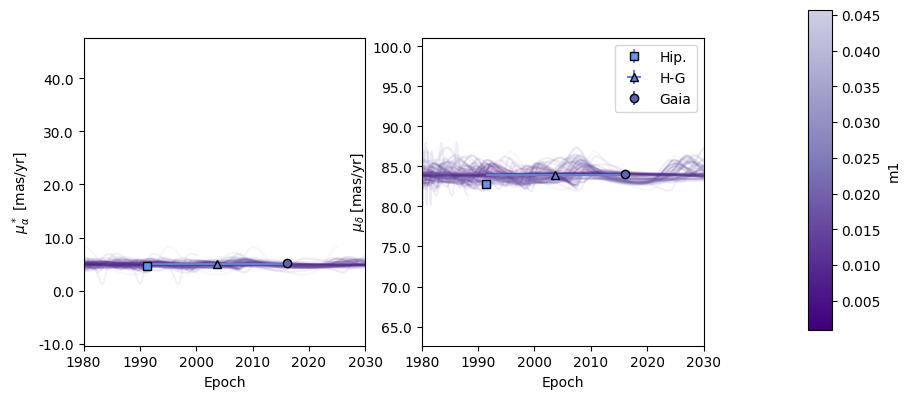

In [4]:
figure = this_sampler.results.plot_propermotion(
    cbar_param="m1", alpha=0.1, periods_to_plot=3
)